In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# VASP - Surface formation energy
In this example, we want to introduce how to perform VASP calcultions using strucscan and calculate the formation energy of an example (100) fcc surface in Ni. This examples requires the two prerequisites:
* a licensed VASP version
* a configured resource directory including the neccessary POTCAR for Ni

In the documentation it is explained how to set up the resource directory for VASP. We will also need a settings template. For this, you can stick to the default one that comes with the repository. We will perform a spin-polarised calculation with an energy cut-off of 500 eV:

In [2]:
! cat ../resources/engines/vasp/settings/500_SP.incar

! ISIF and IBRION flags will be set automatically by strucscan
ALGO            = Fast
PREC            = Accurate
EDIFF           = 1e-05
NSW             = 100
NELM            = 60
LREAL           = .FALSE.
LWAVE           = .FALSE.
ISPIN           = 2
LCHARG          = .FALSE.
LORBIT          = 11
ENCUT           = 500


## The structure
Let's have a look at our surface structure we want to investigate:

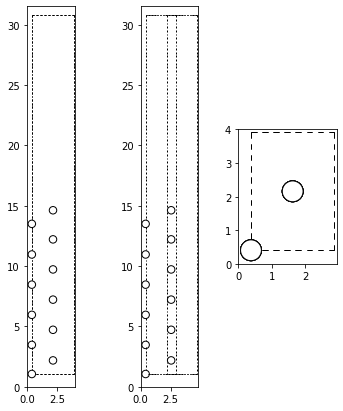

In [3]:
from ase.visualize.plot import plot_atoms
from ase import io

structname = "../structures/unaries/surfaces/fcc_110surf_12at.cfg"
atoms = io.read(structname, format="cfg")

fig, axs = plt.subplots(1, 3, figsize=(6,7))
for ind, rotation in enumerate(['90x,90y', '90x,45y', '0x']):
    plot_atoms(atoms, rotation=(rotation), ax=axs[ind])
plt.show()

## The `input` dictionary
The next step is to set up the input dictionary properly. We can either start from scatch as in the precedubf example or start right-away with the pre-implemented example for vasp:

In [4]:
from strucscan.resources.inputyaml import * 
input_dict = VASP().EXAMPLE
input_dict

{'species': 'Ni Al_pv',
 'engine': 'VASP 5.4',
 'machine': 'example_vasp',
 'ncores': '1',
 'nnodes': '1',
 'queuename': 'none',
 'potential': 'PBE',
 'properties': 'atomic',
 'prototypes': 'L1_2',
 'settings': '500_SP.incar',
 'magnetic configuration': 'SP',
 'initial magnetic moments': '2.0 0.',
 'kdens': '0.15',
 'kmesh': 'Monkhorst-pack',
 'initial atvolume': 'default',
 'verbose': False,
 'monitor': True,
 'submit': True,
 'collect': False}

The example `input` is already configured for our example machine `vasp_example` which features no queueing system but we need to adapt some values:

In [5]:
input_dict.update({"species": "Ni",
                   "potentials": "PBE",
                   "properties": "atomic",
                   "prototypes": "fcc.cfg fcc_110surf_12at.cfg",
                   "initial magnetic moments": "2.0",
                   "kdens": "0.15",
                   "verbose": True})
input_dict

{'species': 'Ni',
 'engine': 'VASP 5.4',
 'machine': 'example_vasp',
 'ncores': '1',
 'nnodes': '1',
 'queuename': 'none',
 'potential': 'PBE',
 'properties': 'atomic',
 'prototypes': 'fcc.cfg fcc_110surf_12at.cfg',
 'settings': '500_SP.incar',
 'magnetic configuration': 'SP',
 'initial magnetic moments': '2.0',
 'kdens': '0.15',
 'kmesh': 'Monkhorst-pack',
 'initial atvolume': 'default',
 'verbose': True,
 'monitor': True,
 'submit': True,
 'collect': False,
 'potentials': 'PBE'}

Please note that might want to adapt the machine `conifg.yaml` to the machine on which you are running VASP. In this example, the `config.yaml` looks as in the following:

In [6]:
from pprint import pprint
import yaml
with open("../resources/machineconfig/example_vasp/config.yaml", "r") as stream:
        config = yaml.safe_load(stream)
pprint(config)

{'VASP': {'serial': 'module load vasp/5.4.4\nvasp_std\n'},
 'scheduler': 'noqueue',
 'smallest queue': None}


We also added `fcc.cfg` to our list of prototypes. This is our reference structure that we need to calculate the formation energy finally. Now, we can get started:
## Running strucscan

In [ ]:
from strucscan.core.jobmanager import JobManager

JobManager(input_dict)

Data tree path:                /home/users/pietki8q/git/strucscan-master/data
Structure repository:          /home/users/pietki8q/git/strucscan-master/structures
Resource repository:           /home/users/pietki8q/git/strucscan-master/resources

Optional key 'k points file' not provided. Default value will be used: (None)


key:                           : your input                                         what strucscan reads                              
----------------------------------------------------------------------------------------------------
species                        : Ni                                                 Ni                                                
engine                         : VASP 5.4                                           VASP 5.4                                          
machine                        : example_vasp                                       example_vasp                                      
ncores                         : 

## Determining surface formation energy
After finishing successfully strucscan safes the data from the calcultion in pickled dictionaries.

In [ ]:
! ls ../data/VASP_5_4__500_kdens_0_150_SP_PBE/

In [ ]:
import json

with open("../../VASP_5_4__500_kdens_0_150_SP_PBE__Ni__output_dict.yaml") as stream:
    output_dict = json.load(stream)
    stream.close()

from pprint import pprint
pprint(output_dict)

In order to calculate the surface formation energy, we also need to determine the surface area:

$$
\gamma_{surf} = \frac{E_{surf} - E_{ideal}}{2 A}
$$

For this, we need to read the final surface structure manually.

In [9]:
from ase import io

surface_atoms = io.read("../../data/VASP_5_4__500_kdens_0_150_SP_PBE/Ni/atomic__fcc_110surf_12at__Ni12/OUTCAR.gz", format="vasp-out")
surface_atoms

Atoms(symbols='Ni12', pbc=True, cell=[1.978349761, 2.797335995, 23.740192654], calculator=SinglePointDFTCalculator(...))

In [11]:
eV_A2_to_mJ_m2 = 1.60218e-19 * 1e20 * 1e3

surface_structure_energy = output_dict["atomic__fcc_110surf_12at__Ni12"]["structure_energy"]
surface_n_at = output_dict["atomic__fcc_110surf_12at__Ni12"]["n_atom"]
surface_area = np.linalg.det(surface_atoms.get_cell()[:2, :2])

basis_ref_energy = output_dict["atomic__fcc__Ni"]["structure_energy"]
basis_ref_n_atom = output_dict["atomic__fcc__Ni"]["n_atom"]

surface_formation_energy = (surface_structure_energy / surface_n_at - basis_ref_energy / basis_ref_n_atom) / (2 * surface_area)
print(surface_formation_energy * eV_A2_to_mJ_m2)

1379.5079416851156
